<a href="https://colab.research.google.com/github/Nganle21/Big-Data-Dreamteam/blob/main/Ngan/Trained_notebooks/Lyrics_Gen_electronic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


start fr here!

In [ ]:
text = open('/content/drive/MyDrive/Colab Notebooks/text_electronic.txt', 'rb').read().decode(encoding='utf-8')

In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

53 unique characters


In [ ]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
# Batch size
BATCH_SIZE = 10

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(10, 100), dtype=tf.int64, name=None), TensorSpec(shape=(10, 100), dtype=tf.int64, name=None))>

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [ ]:
vocab_size

53

In [ ]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(10, 100, 53) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (10, None, 256)           13568     
                                                                 
 gru (GRU)                   (10, None, 1024)          3938304   
                                                                 
 dense (Dense)               (10, None, 53)            54325     
                                                                 
Total params: 4,006,197
Trainable params: 4,006,197
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [ ]:
sampled_indices

array([32, 33, 23,  6, 43, 28, 47, 16, 40, 42, 20,  9, 15, 12, 17, 27,  4,
       42,  5, 13, 21, 45, 21, 31, 51, 22, 38, 47, 41, 49, 42, 40, 22, 24,
       18, 25, 47, 26, 35, 18, 35, 50, 42, 27, 11, 49, 31, 40, 25, 38, 19,
        9, 15, 41,  1, 35,  1, 51, 48, 21, 46, 25,  3, 40, 50, 23, 44, 22,
       44,  3,  0, 28, 40, 48, 19, 39, 27, 27, 41, 28, 44, 11, 44,  8, 11,
        4, 40, 11, 48, 38, 21, 20, 15, 14, 41, 46, 14, 28, 52,  3])

In [ ]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_electronic'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
my_callbacks = [es,checkpoint_callback]

In [ ]:

model.compile(optimizer='adam', loss=loss)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS=50

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=my_callbacks)

Epoch 1/50
483/483 [==============================] - 14s 25ms/step - loss: 2.0380
Epoch 2/50
483/483 [==============================] - 13s 25ms/step - loss: 1.2268
Epoch 3/50
483/483 [==============================] - 13s 25ms/step - loss: 0.8256
Epoch 4/50
483/483 [==============================] - 14s 27ms/step - loss: 0.5863
Epoch 5/50
483/483 [==============================] - 13s 25ms/step - loss: 0.4530
Epoch 6/50
483/483 [==============================] - 13s 26ms/step - loss: 0.3844
Epoch 7/50
483/483 [==============================] - 13s 25ms/step - loss: 0.3454
Epoch 8/50
483/483 [==============================] - 13s 27ms/step - loss: 0.3255
Epoch 9/50
483/483 [==============================] - 13s 26ms/step - loss: 0.3178
Epoch 10/50
483/483 [==============================] - 13s 26ms/step - loss: 0.3105
Epoch 11/50
483/483 [==============================] - 13s 25ms/step - loss: 0.3095
Epoch 12/50
483/483 [==============================] - 13s 25ms/step - loss: 0.3132
E

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_14'

In [ ]:

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            13568     
                                                                 
 gru_1 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_1 (Dense)             (1, None, 53)             54325     
                                                                 
Total params: 4,006,197
Trainable params: 4,006,197
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def generate_text(model, start_string,t):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 500

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = t

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))


In [ ]:
print(generate_text(model, start_string=u"i just called to say",t=0.2))

i just called to say
whe're the beat it all breate dand feep a the got the beate
i ke the do thate to be the do the beate of my light in my the do this on on
me me gonna get to get the beates and the on a pall nothing our hurn on the way
we gott our freed
we got the soow oh oh
where's is reas rome on of my it dow it to be to be the do that it of my baby, you gonna get the under

ohou go be the in the way what in the rock you are with the on a salles
and in my be and the be
the me and i've to be the do tha


In [ ]:
from keras.models import load_model
#To be used later; I am saving the model 
model.save("/content/drive/MyDrive/Colab Notebooks/electronic_model.h5")

In [ ]:
from tensorflow import keras
a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/electronic_model.h5")

[Text(0.5, 0, 'Epochs')]

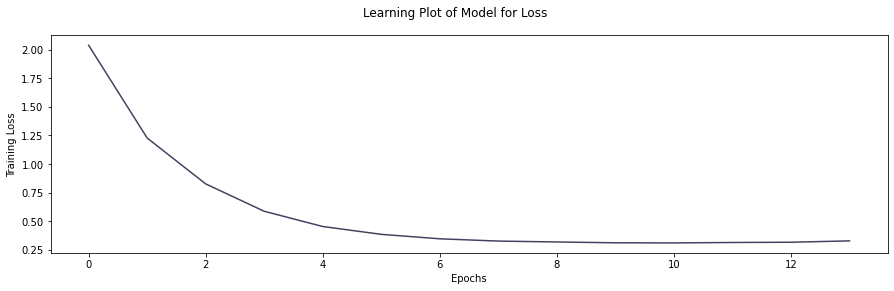

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
history_df = pd.DataFrame(history.history)
#Plotting the learnings 

fig = plt.figure(figsize=(15,4))
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [ ]:
import json
with open('/content/drive/MyDrive/Colab Notebooks/electronic_history.json', 'w') as f:
    json.dump(history.history, f)